In [4]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.sparse import hstack
import re
import shap


In [6]:
# Load data
used_columns = [
    'subscriber_count', 'mean_views_last_30_videos', 'median_views_last_30_videos',
    'std_views_last_30_videos', 'videos_per_week',
    'description', 'keywords', 'total_views', 'join_date', 'channel_name'
]
df = pd.concat(pd.read_csv('Youtube_miljon.csv', usecols=used_columns, chunksize=100_000), ignore_index=True)
df = df.drop_duplicates()
df = df[df['total_views'] <= df['total_views'].quantile(0.99)]
df['subscriber_count'] = df['subscriber_count'].clip(upper=10_000_000)

# Fill missing values
fillna_cols = ['mean_views_last_30_videos', 'median_views_last_30_videos', 'std_views_last_30_videos', 'videos_per_week']
for col in fillna_cols:
    df[col] = df[col].fillna(df[col].median())
df['description'] = df['description'].fillna("")
df['keywords'] = df['keywords'].fillna("")
df['channel_name'] = df['channel_name'].fillna("")
df['join_date'] = pd.to_datetime(df['join_date'], errors='coerce')
df['weekday'] = df['join_date'].dt.weekday.fillna(0).astype(int)


In [8]:
# Features
df['title_length'] = df['channel_name'].apply(lambda x: len(str(x)))
df['title_question'] = df['channel_name'].apply(lambda x: int('?' in str(x)))
df['title_symbols'] = df['channel_name'].apply(lambda x: len(re.findall(r'[!@#\$%\^&\*]', str(x))))
df['caps_ratio'] = df['channel_name'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(x) if len(x) > 0 else 0)
df['has_number_in_title'] = df['channel_name'].apply(lambda x: int(bool(re.search(r'\d', str(x)))))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))
df['keyword_count'] = df['keywords'].apply(lambda x: len(str(x).split(',')))
df['views_per_subscriber'] = df['total_views'] / (df['subscriber_count'] + 1)
df['log_views_per_sub'] = np.log1p(df['views_per_subscriber'])

# Preprocess
numeric_features = [
    'subscriber_count', 'mean_views_last_30_videos', 'median_views_last_30_videos',
    'std_views_last_30_videos', 'videos_per_week', 'title_length', 'title_question', 'title_symbols',
    'caps_ratio', 'has_number_in_title', 'description_length', 'keyword_count', 'weekday'
]
df = df.dropna(subset=numeric_features + ['description', 'keywords', 'channel_name'])
X_num = df[numeric_features].values.astype(np.float32)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
svd = TruncatedSVD(n_components=150)
X_text = svd.fit_transform(vectorizer.fit_transform(df['description'] + " " + df['keywords'] + " " + df['channel_name']))

X = np.hstack([X_num_scaled, X_text])
y = df['log_views_per_sub'].values


In [10]:
# Structure for Model
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(inputs)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

In [44]:
# Train, K-Fold CV (3 folds) and EarlyStopping 
kf = KFold(n_splits=3)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n[Fold {fold + 1}]")
    model = build_model(X.shape[1])
    model.compile(optimizer='adam', loss='mae')

    early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)




[Fold 1]

[Fold 2]

[Fold 3]


In [25]:
    model.fit(
        X[train_idx], y[train_idx],
        validation_data=(X[val_idx], y[val_idx]),
        epochs=30,                  # kortare träning
        batch_size=128,
        callbacks=[early_stop],
        verbose=1                   # se progress
    )

    preds = model.predict(X[val_idx]).flatten()
    score = mean_absolute_error(y[val_idx], preds)
    mae_scores.append(score)
    print(f"MAE för fold {fold + 1}: {score:.4f}")

print(f"\nAverage MAE: {np.mean(mae_scores):.4f}")


Epoch 1/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 1.3277 - val_loss: 1.0470
Epoch 2/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.1606 - val_loss: 0.9830
Epoch 3/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 1.1368 - val_loss: 0.9720
Epoch 4/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 1.1284 - val_loss: 0.9704
Epoch 5/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 1.1193 - val_loss: 0.9737
Epoch 6/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 1.1211 - val_loss: 0.9653
Epoch 7/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 1.1150 - val_loss: 0.9648
Epoch 8/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 1.1122 - val_loss: 0.9629
Epoch 9/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.1105 - val_loss: 0.9640
Epoch 10/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.1058 - val_loss: 0.9581
Epoch 11/30
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.1049 - val_loss: 0.9546
Epoch 12/30
5644/56


≈ 2 view for each sub, average wrong
SHAP-value


PermutationExplainer explainer: 101it [00:19,  2.54it/s]                         


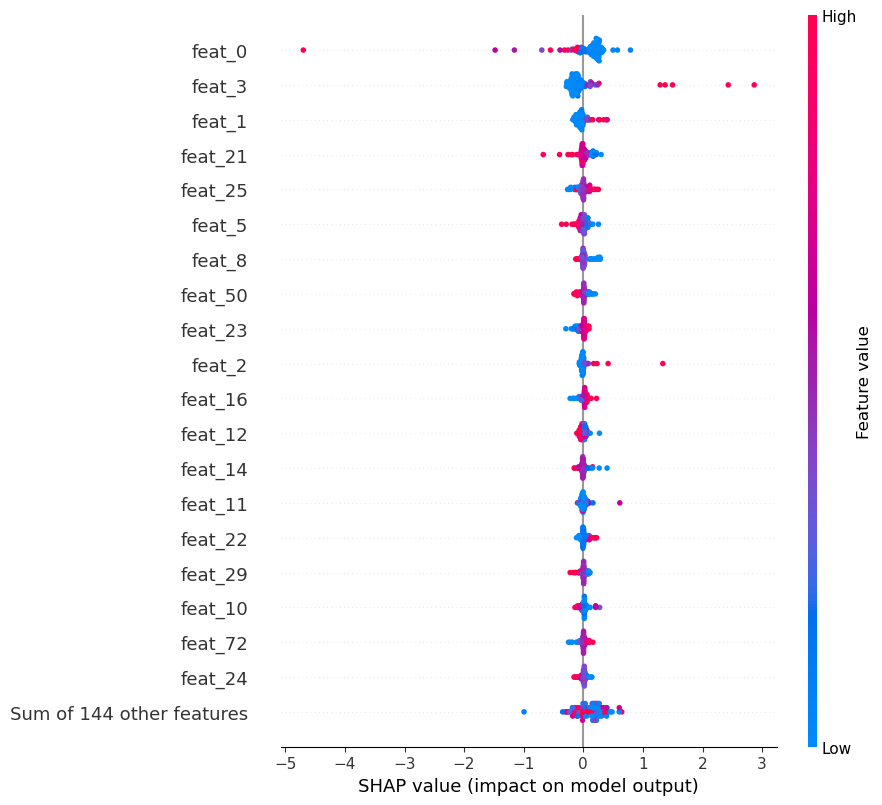

In [42]:
# MAE real scale
real_mae = np.expm1(np.mean(mae_scores))
print(f"\n≈ {real_mae:.0f} view for each sub, average wrong")

# Sharp Feature Importance (fold 3:s model + val_data) 

print("SHAP-value")
explainer = shap.Explainer(model, X[val_idx], feature_names=[f'feat_{i}' for i in range(X.shape[1])])
shap_values = explainer(X[val_idx][:100])  # max 100 

shap.plots.beeswarm(shap_values, max_display=20)


In [38]:
# Combine name, real features
num_features = [
    'subscriber_count', 'mean_views_last_30_videos', 'median_views_last_30_videos',
    'std_views_last_30_videos', 'videos_per_week', 'title_length', 'title_question',
    'title_symbols', 'caps_ratio', 'has_number_in_title', 'description_length',
    'keyword_count', 'weekday'
]
text_features = [f'text_svd_{i}' for i in range(150)]  # eftersom du körde TruncatedSVD med 150 komponenter
feature_names = num_features + text_features


PermutationExplainer explainer: 101it [00:20,  2.56it/s]                         
C:\Users\Lunda\AppData\Local\Temp\ipykernel_6068\942304752.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X[val_idx][:100], feature_names=feature_names)


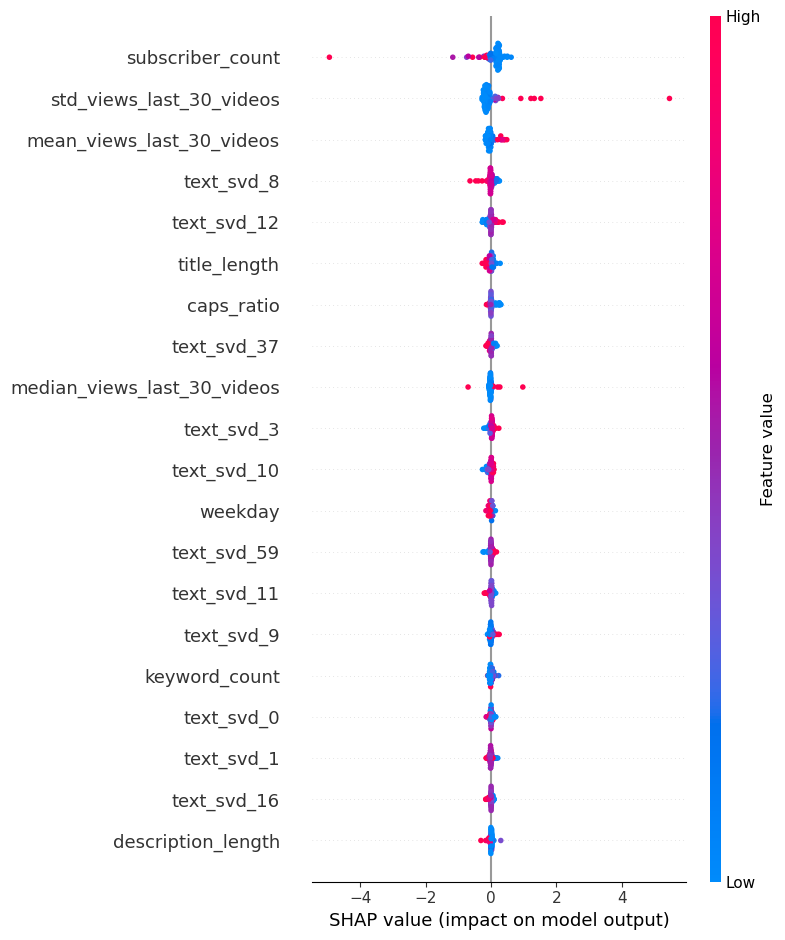

In [34]:
explainer = shap.Explainer(model, X[val_idx], feature_names=feature_names)
shap_values = explainer(X[val_idx][:100])
shap.summary_plot(shap_values.values, X[val_idx][:100], feature_names=feature_names)


In [36]:
#Top 20 features
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_shap
}).sort_values(by="importance", ascending=False)

top_20 = shap_df.head(20)
display(top_20)


,feature,importance
0,subscriber_count,0.259690
3,std_views_last_30_videos,0.237608
1,mean_views_last_30_videos,0.088949
21,text_svd_8,0.068385
25,text_svd_12,0.063710
5,title_length,0.052087
8,caps_ratio,0.050640
50,text_svd_37,0.043133
2,median_views_last_30_videos,0.042641
16,text_svd_3,0.042309


In [56]:
#word-content
components = svd.components_  # [150 x 10000] matris
vectorizer_vocab = vectorizer.get_feature_names_out()

# Topp-word_156, contains
comp_56 = components[56]
top_word_indices = comp_56.argsort()[::-1][:10]
top_words = [(vectorizer_vocab[i], comp_56[i]) for i in top_word_indices]
print(top_words)


[('with', 0.40064945153275294), ('family', 0.3033638236596713), ('recipes', 0.14886147946363826), ('media', 0.14851824275711897), ('is', 0.13957003332136234), ('videos', 0.11037030499048961), ('reviews', 0.10815615892482452), ('share', 0.1063606760122034), ('to', 0.10467145521047752), ('home', 0.09580893641115999)]


In [58]:
#Top Word_141
[('subscribe', 0.32), ('video', 0.28), ('new', 0.26), ...]


[('subscribe', 0.32), ('video', 0.28), ('new', 0.26), Ellipsis]